In [52]:
from math import sqrt

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch as th
from torch import vstack, hstack, tensor
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, TensorDataset


from quantum import coherent_ket
from loss import phase_insensitive_povm_loss
from utils import random_stiefel, unstack, check_povm_validity, grid_points, plot_matrix, on_stiefel

In [53]:
M = 100  # number of POVM outcomes
N = 100  # Hilbert space dimension

### True POVMs

In [54]:
logits = th.rand((M, N)) - 1  # uniform random range (-1,1)
probs = th.softmax(logits, dim=0).to(dtype=th.complex128)  # cols are probability vectors
print("First col sum is: ",sum(probs[:, 0]).item())
true_povm = [ th.diag(probs[i, :]) for i in range(M) ]  # row i is the diagonal of povm element E_i


# NOTE: for this POVM to be valid we must have M=N
# true_povm = []
# for m in range(M):
    
#     povm_diag = th.zeros(N, dtype=th.complex128)
#     povm_diag[m] = 1.0
#     true_povm.append( th.diag(povm_diag) )

print(f'Is true POVM valid? {"Yes" if check_povm_validity(true_povm) else "No"}')

First col sum is:  (0.9999998165294528+0j)
Is true POVM valid? Yes


In [55]:
# probs = th.softmax(logits, dim=0).to(dtype=th.complex128)
# s = 0
# for n in range(N):
#     for m in range(M-1):
#         s += (probs[m, n] - probs[m+1,n])**2

### Probe states

In [56]:
num_probes = 400
max_amp = 5  #sqrt(3.0)   # max coordinate in phase space that will be spanned in one direction is max_amp^2

# generate num_probes^2 state probes each from circles of increasing radius
# complex_amps = np.array([circle_points(num_probes, R=R) for R in np.linspace(0.1, max_amp, num_probes) ]).flatten()
# complex_amps = grid_points(num_probes, xlim=(-max_amp, max_amp), ylim=(-max_amp, max_amp), dtype=th.complex128)
complex_amps = np.linspace(0, max_amp, num_probes)

probes = vstack([ coherent_ket(alpha, N) for alpha in complex_amps ])

print(f"Shape of probes is: {list(probes.shape)} should be {[num_probes, N]}.")

Shape of probes is: [400, 100] should be [400, 100].


### Target matrix 

Shape of targets is: [400, 100] should be [400, 100].


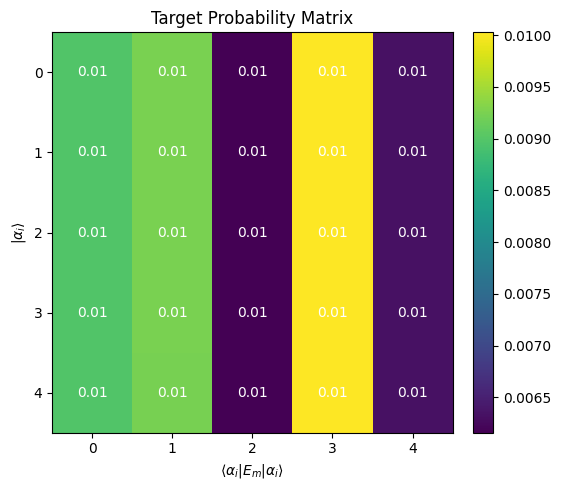

In [57]:
targets = th.einsum("bi,mij,bj->bm", probes.conj(), th.stack(true_povm), probes).real

print(f"Shape of targets is: {list(targets.shape)} should be {[num_probes, M]}.")

for i in range(targets.shape[0]):
    if th.sum(targets[0]).item() - 1.0 > 1e-6:
        print(f"Warning: Sum of target probabilities for probe {i} is {th.sum(targets[i]).item()} (should be 1.0)")


plot_matrix(
    targets.numpy()[:5, :5],
    title="Target Probability Matrix",
    cmap="viridis",
    show_values= not False,
    xlabel=r"$\langle \alpha_i|E_m|\alpha_i\rangle$",
    ylabel=r"$|\alpha_i\rangle$",
    colorbar=True,
    figsize=(6, 5),
    vmin=None,
    vmax=None
)

### Training

In [58]:
lam = 0*1e-5  # regularization weight
current_lr = 0.01  # learning rate
lr_decay = 0.999  # learning rate decay factor
device = 'cuda'

logits = th.rand((M, N)) - 1
logits = logits.to(device)
logits.requires_grad = True

optimizer = Adam([logits], lr=current_lr)
scheduler = ExponentialLR(optimizer, gamma=lr_decay) # Decay LR by gamma every time called

probes = probes.to(device)
targets = targets.to(device)
dataset = TensorDataset(probes, targets)

# Create DataLoader
batch_size = 100
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [59]:
iterations = 550
I = th.eye(2*N, dtype=th.complex128).to(device) # identity matrix for retraction step
losses = []
lr_vals = []

for step in tqdm(range(iterations), desc="Learning POVM"):
    lr_vals.append(scheduler.get_last_lr())
    batch_losses = []

    for probes_batch, targets_batch in loader:
        optimizer.zero_grad()

        # Compute batch loss
        L = phase_insensitive_povm_loss(targets_batch, logits, probes_batch, lam)

        L.backward()

        optimizer.step()
        
        batch_losses.append(L.item())
        current_lr *= lr_decay  # decay learning rate manually

    scheduler.step()
    losses.append(sum(batch_losses) / len(batch_losses))

Learning POVM: 100%|██████████| 550/550 [01:13<00:00,  7.51it/s]


Final loss: 8.265230654746268e-07


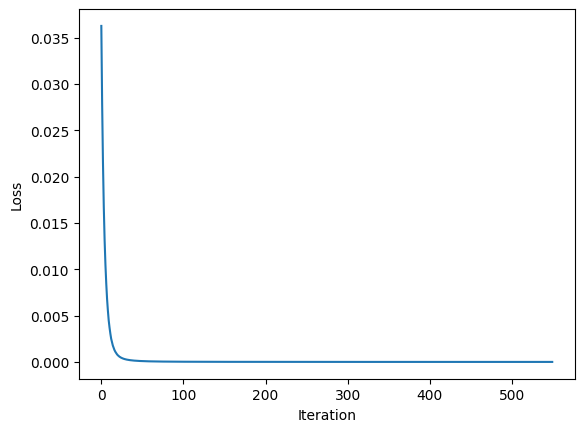

In [60]:
print("Final loss:", losses[-1])
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.plot(losses);

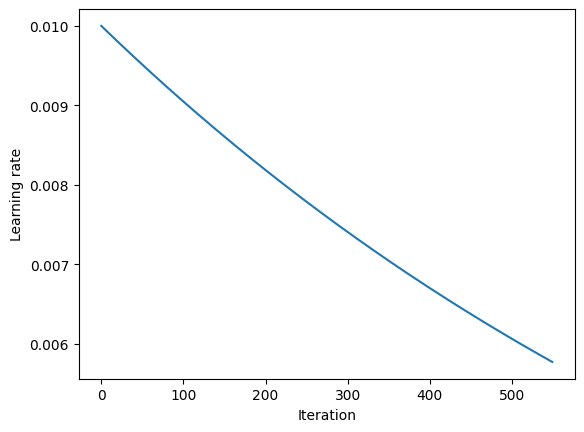

In [61]:
plt.ylabel('Learning rate')
plt.xlabel('Iteration')
plt.plot(lr_vals);

In [62]:
from qutip import fidelity, Qobj

with th.no_grad():
    probs = th.softmax(logits, dim=0).to(dtype=th.complex128)  # cols are probability vectors
    pred_povm = th.stack([ th.diag(probs[i, :]) for i in range(M) ]).to("cpu")

    print(f'Is predicted POVM valid? {"Yes" if check_povm_validity(pred_povm) else "No"}')

    print("Fidelities", [ th.real(fidelity(Qobj(pred_povm[i]), Qobj(true_povm[i]))**2 / (th.trace(true_povm[i])*th.trace(pred_povm[i]))).item() for i in range(M) ])
    #print("Rel errors", [ 100*th.linalg.norm(pred_povm[i] - true_povm[i], ord="fro").item() / th.linalg.norm(true_povm[i], ord="fro").item() for i in range(M) ])
    print("Dist: ", sqrt(sum([ th.linalg.norm(pred_povm[i] - true_povm[i], ord="fro").item()**2 for i in range(M) ])) )
    print( "pred_pov - true_povm:", round(th.sum((pred_povm - th.stack(true_povm)) ** 2).item().real, 3) )

Is predicted POVM valid? Yes
Fidelities [0.9688354722334516, 0.9690993634269682, 0.9695949728015257, 0.9682885889975056, 0.960753738148048, 0.9590149520196268, 0.9677115320057228, 0.9655028560856372, 0.9699873221107446, 0.9626028130175429, 0.9618767177126565, 0.9678560129248538, 0.9648924613916032, 0.9615241014927685, 0.9557563661120069, 0.9652970957308159, 0.9647884879475701, 0.9647971356477504, 0.9653568696797019, 0.9665931649094451, 0.9677287447151979, 0.9694915541899563, 0.9715524291000435, 0.9558373302692803, 0.9719165793222971, 0.9599609944401178, 0.9529343164048436, 0.9664874316433609, 0.9655925821120568, 0.9711070370347927, 0.9682046984815568, 0.9643337731024668, 0.9581080201393972, 0.9706415398116914, 0.9582791298114374, 0.9636476397157858, 0.9651051852337598, 0.962841574548834, 0.9586517150526104, 0.9635483964831532, 0.9685291574288798, 0.9579226712157705, 0.9601751082219471, 0.9640938794715445, 0.9699991316089137, 0.9553915366389027, 0.9608502679350043, 0.9626634643205882, 0